<a href="https://colab.research.google.com/github/sarahjoseph22194-cmyk/SnP500_Prediction/blob/main/Stock_Market_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
import yfinance as yf

In [74]:
sp500=yf.Ticker("^GSPC")

In [75]:
sp500 = sp500.history(period="max")

<Axes: xlabel='Date'>

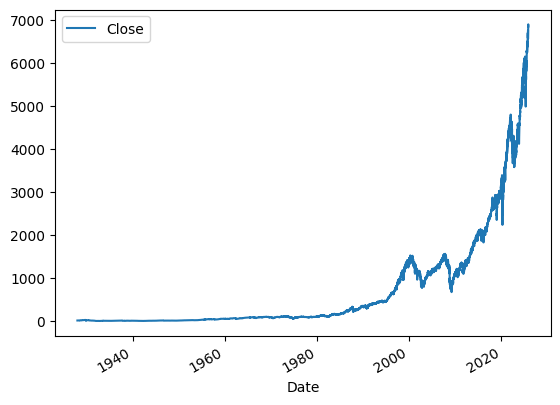

In [76]:
sp500.plot.line(y="Close", use_index=True)

In [77]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [78]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [79]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [80]:
sp500 = sp500.loc["1990-01-01":].copy()

In [81]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=150, min_samples_split=150,random_state=1)
train = sp500.iloc[:-100]
test = sp500.iloc[-100:]
predictors=["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=150, n_estimators=150, random_state=1)

In [82]:
from sklearn.metrics import precision_score
preds = model.predict(test[predictors])

In [83]:
import pandas as pd
preds = pd.Series(preds, index=test.index)

In [84]:
precision_score(test["Target"], preds)

0.5

In [85]:
combined = pd.concat([test["Target"], preds], axis=1)

<Axes: xlabel='Date'>

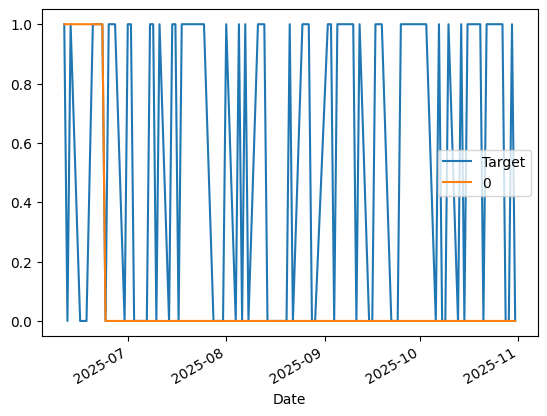

In [86]:
combined.plot()

In [87]:
def prediction(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [88]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = prediction(train, test, predictors, model)
        all_predictions.append(predictions)

    return pd.concat(all_predictions)


In [89]:
predictions = backtest(sp500, model, predictors)

In [90]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3570
1,2956


In [91]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5331529093369418

In [92]:
predictions["Target"].value_counts() / predictions.shape[0]

,count
Target,
1,0.537236
0,0.462764


In [93]:
horizons = [2,5,60,250,1000]

new_pridctors = []
for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
    new_pridctors += [ratio_column, trend_column]

In [94]:
sp500 = sp500.dropna()

In [95]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [102]:
def prediction(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .75] = 1
    preds[preds < .75] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [104]:
predictors = backtest(sp500, model, new_pridctors)

In [107]:
predictions["Predictions"].value_counts()

,count
Predictions,
0,3570
1,2956


In [108]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5331529093369418